In [1]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [2]:
# 함수

def outliers_iqr(data) :
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    lower_bound = 0
    upper_bound = 3000

    return np.where((data > upper_bound)|(data<lower_bound))

def get_outlier(df=None, column=None, weight=1.5):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

In [3]:
# 데이터 로드

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 무역 데이터 확인

filename = '/content/drive/MyDrive/데이터사이언스모임/무역데이터_베트남/무역_베트남.csv'
vietnam = pd.read_csv(filename)
vietnam.head(10)

,EXPOR_NTN_NM,HS_CD,ARRVL_YRMNT,VTNM_TRAD_INVCE_AMT,ARRVL_PRT_NM
0,CHINA,85322400,2021-02-22,10.92,VNCLI
1,CHINA,85030090,2021-02-22,224.32,VNCLI
2,CHINA,84733090,2021-02-22,3840.00,VNSGN
3,CHINA,82075000,2021-02-22,62.00,VNCLI
4,CHINA,85076090,2021-02-22,9.15,VNSGN
5,CHINA,84439990,2021-02-22,155073.60,VNDVU
6,CHINA,85423900,2021-02-22,2278.62,VNDVU
7,CHINA,85444299,2021-02-22,16.65,VNHAN
8,CHINA,83082000,2021-02-22,8.70,VNCLI
9,CHINA,84241090,2021-02-22,1290.00,VNDTS


# 1. 기본정보 확인

EXPOR_NTN_NM, HS_CD, ARRVL_YRMNT, ARRVL_PRT,NM은 **범주형 변수**

VTNM_TRAD_INVCE_AMT는 **수치형 변수**로 파악된다.


컬럼정의서에 따르면 각 컬럼의 의미는 다음과 같다.

1. EXPOR_NTM_NM : 수출국가명
2. HS_CD : HS코드
3. ARRVL_YRMNT
4. VTNM_TRAD_INVCE_AMT : 베트남무역송장금액
5. ARRVL_PRT_NM : 도착항구명

무역데이터에 대한 상향식 접근 방식(Bottom Up Approach)을 고민해볼 것이다.

* 상향식 접근 방식(Bottom Up Approach) : 문제의 정의 자체가 어려운 경우, 데이터를 기반으로 문제의 재정의 및 해결방안을 탐색하고, 이를 지속적으로 개선하는 방식

데이터 분석을 진행하고 싶은 사항은 다음과 같다.

1. HSCODE별 평균 가격 중 높은 순서로 분석

2. 항구별 HSCODE 빈도수가 높은 것

3. 전체 항구의 거래량 파악 : ARRVL_YRMNT 빈도수 파악

In [8]:
vietnam.shape

(9999, 5)

5개의 Column이 있다.

In [9]:
vietnam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   EXPOR_NTN_NM         9999 non-null   object 
 1   HS_CD                9999 non-null   int64  
 2   ARRVL_YRMNT          9999 non-null   object 
 3   VTNM_TRAD_INVCE_AMT  9999 non-null   float64
 4   ARRVL_PRT_NM         9999 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 390.7+ KB


In [12]:
# VTNM_TRAD_INVCE_AMT에 대한 기술통계 Summary
vietnam['VTNM_TRAD_INVCE_AMT'].describe()

count    9.999000e+03
mean     3.891812e+05
std      5.702677e+06
min      0.000000e+00
25%      9.000000e+01
50%      5.250000e+02
75%      3.040380e+03
max      2.409840e+08
Name: VTNM_TRAD_INVCE_AMT, dtype: float64

기술통계값을 확인해보니, 최소 송장금액이 0인 값이 존재하는 것을 보아, 모델에 오류를 불러일으킬만한 데이터가 존재함을 확인할 수 있다.

<<< 여기에 송장금액이 0인 데이터를 삭제하는 코드를 입력할 것 >>>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


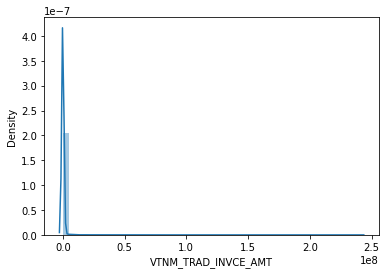

In [13]:
# 히스토그램(histogram)
sns.distplot(vietnam['VTNM_TRAD_INVCE_AMT'])

유감스럽게도, 